In [5]:
#!pip install -U aeon
#!pip install aeon[all_extras]
import warnings
import pandas as pd
from matplotlib import pyplot as plt
from aeon.visualisation import plot_series
from all_functions import *
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 
from sklearn.model_selection import GridSearchCV
from aeon.transformations.detrend import STLTransformer
import ast
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error, make_scorer
warnings.filterwarnings("ignore")
%matplotlib inline

In [6]:
window = 12
horizon = 12
derivad = "etanolhidratado"
estado = "SP"
series = read_series(f'../datasets/venda/mensal/uf/{derivad}/mensal_{estado.lower()}_{derivad}.csv')
train, test = train_test_stats(series, horizon)
transformer = STLTransformer(sp=6)  
result = transformer.fit(train)
train = result.trend_ + result.seasonal_
train_resid = result.resid_
train_trend = result.trend_

# transformer = STLTransformer(sp=12)  
# result = transformer.fit(test)
# test_resid = result.resid_


In [7]:
def get_predictions_csv(path, data, start_index):
    df = pd.read_csv(path, sep=";")
    results = {}
    filtered_df = df[df['DATA'] == data]
    
    columns_p1_to_p12 = filtered_df.loc[:, 'P1':'P12']
    
    values_list = columns_p1_to_p12.values.flatten().tolist()        
    params = filtered_df['PARAMS'].iloc[0]
            
    return pd.Series(values_list, index=start_index), ast.literal_eval(params)


def get_arima_mean(path, data, start_index):
    df = pd.read_csv(path, sep=";")
    results = {}
    filtered_df = df[df['DATA'] == data]
    
    columns_p1_to_p12 = filtered_df.loc[:, 'P1':'P12']
    
    values_list = columns_p1_to_p12.values.flatten().tolist()        
    # params = filtered_df['PARAMS'].iloc[0]
    return pd.Series(values_list, index=start_index)

0.1172911072955768

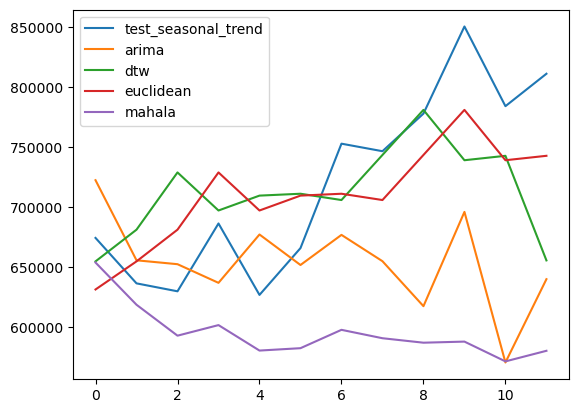

In [8]:
transformer2 = STLTransformer(sp=6)  
ss = transformer2.fit(series)

_, test_stl = train_test_stats(ss.seasonal_, horizon)
_, trend_test = train_test_stats(ss.trend_, horizon)

_, st_test = train_test_stats(ss.seasonal_ + ss.trend_, horizon)

result_stl = f"./results/arima_stl/rolling/etanolhidratado/transform_{estado}.csv"
result_nn = f"./results/nn/rolling/etanolhidratado/transform_{estado}.csv"

trend_stl = get_arima_mean(result_stl, "trend", test)
seasonal_stl = get_arima_mean(result_stl, "seasonal", test)
st_stl = get_arima_mean(result_stl, "seasonal_trend", test)

trend_nn = get_arima_mean(result_nn, "trend_dtw", test)
seasonal_nn = get_arima_mean(result_nn, "seasonal_dtw", test)
st_nn = get_arima_mean(result_nn, "seasonal_trend_dtw", test)

trend_nn2 = get_arima_mean(result_nn, "trend_euclidean", test)
seasonal_nn2 = get_arima_mean(result_nn, "seasonal_euclidean", test)
st_nn2 = get_arima_mean(result_nn, "seasonal_trend_euclidean", test)

trend_nn3 = get_arima_mean(result_nn, "trend_mahalanobis", test)
seasonal_nn3 = get_arima_mean(result_nn, "seasonal_mahalanobis", test)
st_nn3 = get_arima_mean(result_nn, "seasonal_trend_mahalanobis", test)

# plot_series(test_stl.values, seasonal_stl.values, labels=["test", "preds"])
plt.plot(st_test.values)
plt.plot(st_stl.values)
plt.plot(st_nn.values)
plt.plot(st_nn2.values)
plt.plot(st_nn3.values)
# plt.plot(test.values)

plt.legend(["test_seasonal_trend", "arima", "dtw", "euclidean", "mahala"])
mape(st_test.values, st_stl.values)  
# mape(trend_test, trend_stl.values)

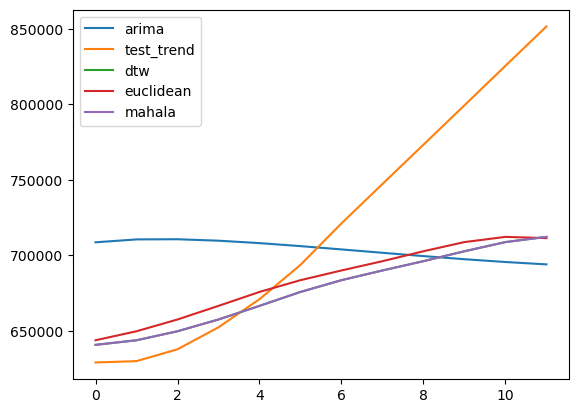

In [9]:
plt.plot(trend_stl.values)
plt.plot(trend_test.values)
plt.plot(trend_nn.values)
plt.plot(trend_nn2.values)
plt.plot(trend_nn3.values)
plt.legend(["arima", "test_trend", "dtw", "euclidean", "mahala"])

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

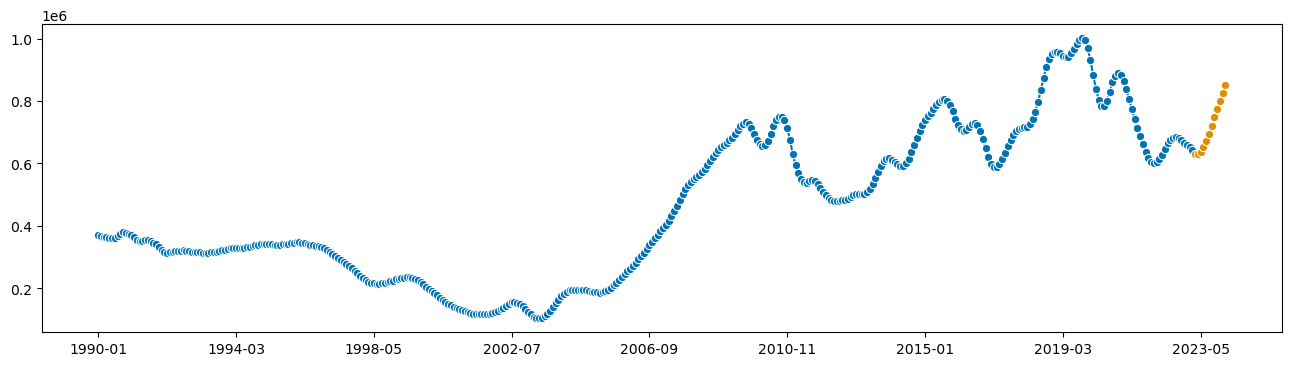

In [10]:
data = ss.trend_[ss.trend_.index >= '2012-01']
plot_series(train_trend,trend_test)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

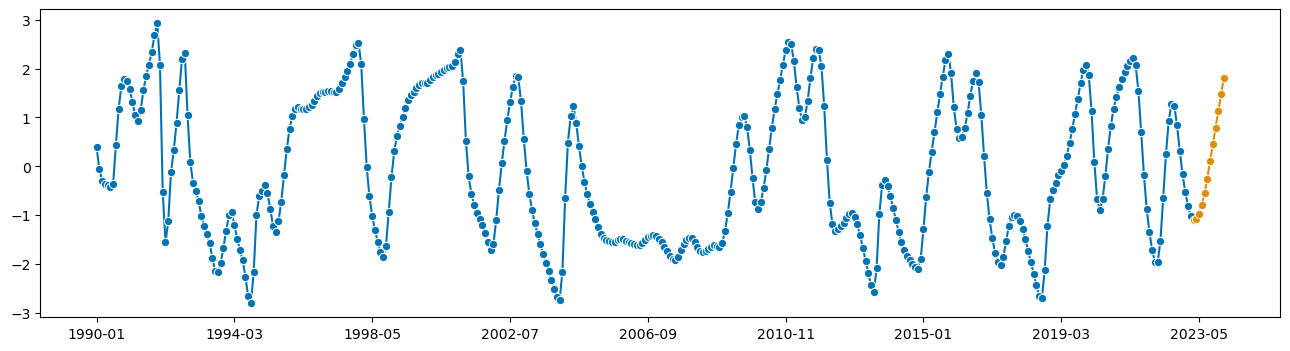

In [12]:
tt, ts = train_test_stats(transform_train(ss.trend_, format="normal"), 12)
tt2, ts2 = train_test_stats(ss.trend_, 12)
plot_series(tt, ts)

In [13]:
k = 1
horizon = 12
s=12
metric = 'euclidean'  # 'euclidean', 'mahalanobis' ou 'dtw'
train_transformed = transform_train(train_trend, format="normal")
results = knn_similar_series(train_transformed[:-s], train_transformed[-s:], k, metric)
results3 = knn_similar_series(train_transformed[:-s], train_transformed[-s:], k, "dtw")
results2 = knn_similar_series(train_trend[:-s], train_trend[-s:], k, metric)

In [14]:
def find_closest_subsequence(series1, series2):
    query_len = len(series2)

    distances = []
    subsequences = []

    for i in range(len(series1) - query_len + 1):
        subsequence = series1.iloc[i:i + query_len]
        # dist = dtw.distance(series2.values, subsequence.values)
        dist = dtw_distance(series2.values, subsequence.values, window=0.2)
        distances.append(dist)
        subsequences.append(subsequence)

    min_dist_index = np.argmin(distances)
    closest_subsequence = subsequences[min_dist_index]

    return closest_subsequence

In [15]:
results3

[{'similar_sequence': timestamp
  2009-01   -1.327101
  2009-02   -0.965776
  2009-03   -0.523318
  2009-04   -0.037491
  2009-05    0.447278
  2009-06    0.837422
  2009-07    1.014639
  2009-08    1.026801
  2009-09    0.811976
  2009-10    0.342382
  2009-11   -0.247288
  2009-12   -0.739629
  Freq: M, dtype: float64,
  'distance': 0.42347499846608755}]

In [16]:
import numpy as np
from dtaidistance import dtw, dtw_visualisation as dtwvis
closest_subsequence = find_closest_subsequence(train_trend[:-s], train_trend[-s:])
similar_norm = find_closest_subsequence(train_transformed[:-s], train_transformed[-s:])
similar_norm

timestamp
2009-01   -1.327101
2009-02   -0.965776
2009-03   -0.523318
2009-04   -0.037491
2009-05    0.447278
2009-06    0.837422
2009-07    1.014639
2009-08    1.026801
2009-09    0.811976
2009-10    0.342382
2009-11   -0.247288
2009-12   -0.739629
Freq: M, dtype: float64

In [17]:
results2

[{'similar_sequence': timestamp
  2008-07    608289.038234
  2008-08    620772.959564
  2008-09    633115.016543
  2008-10    644125.280825
  2008-11    653125.090839
  2008-12    660150.241788
  2009-01    666627.427203
  2009-02    673438.258495
  2009-03    682604.709952
  2009-04    694355.709607
  2009-05    707196.783621
  2009-06    719156.896320
  Freq: M, dtype: float64,
  'distance': 122951.15863115135}]

In [18]:
# _, mean, std = rolling_window_series(train_trend, 12)
# preds_transformed = znorm_reverse(results3[0]['future_sequence'], mean, std)
# preds = pd.Series(preds_transformed.values, ts2.index)
# preds_transformed

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

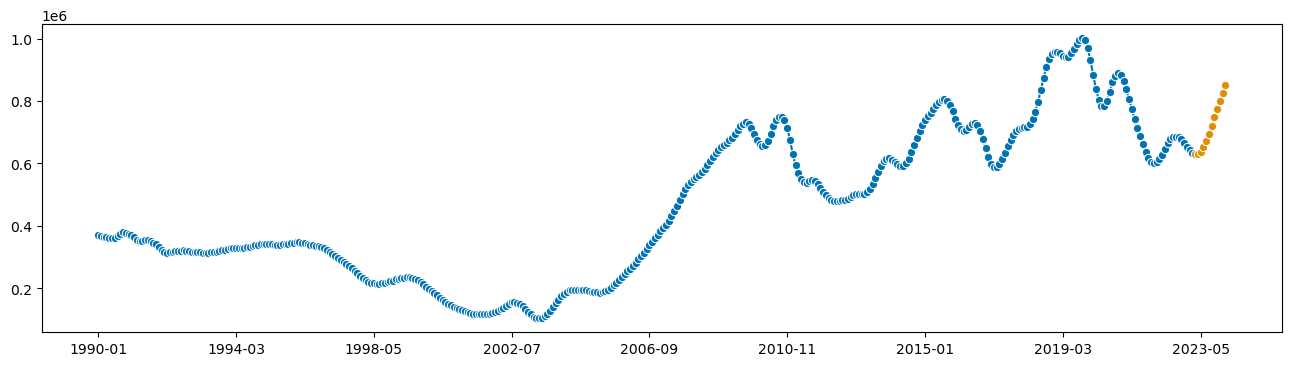

In [19]:
plot_series(tt2, ts2)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

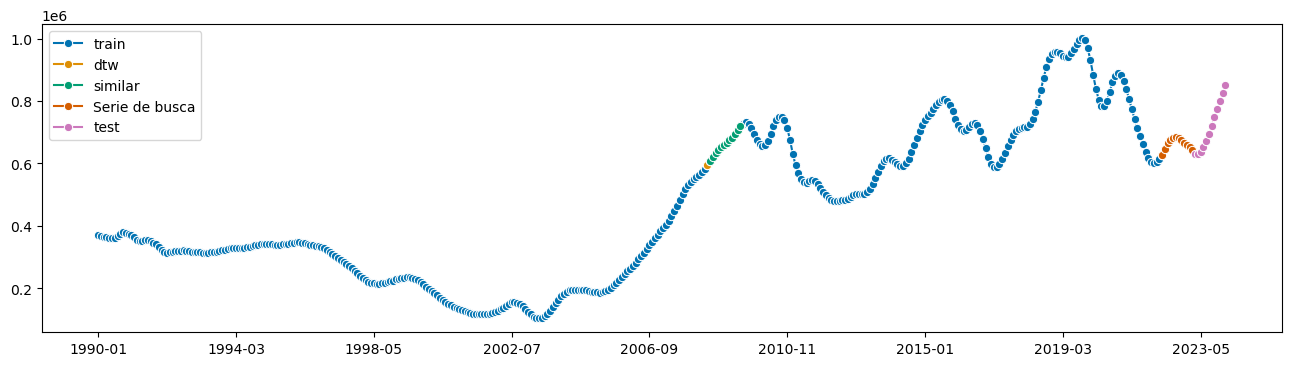

In [20]:
plot_series(train_trend,closest_subsequence, results2[0]['similar_sequence'], train_trend[-s:],ts2, labels=["train", "dtw","similar", "Serie de busca", "test"])

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

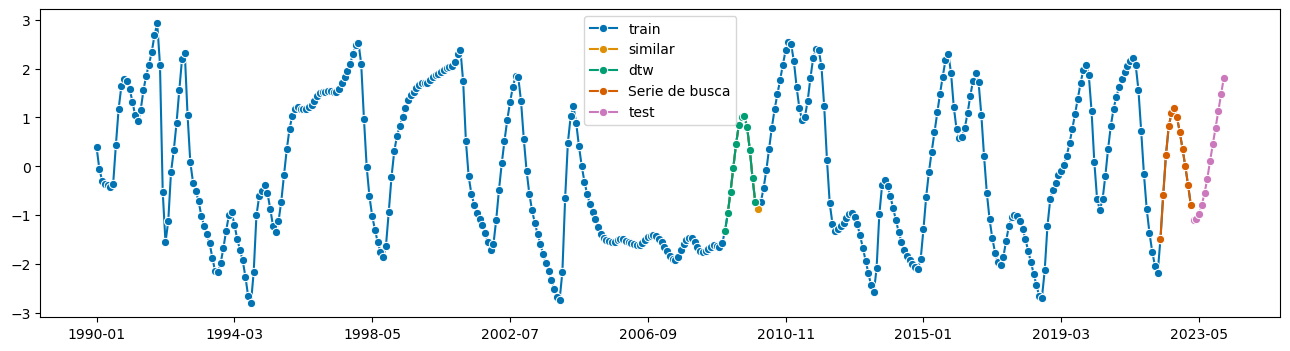

In [21]:
plot_series(train_transformed, results[0]['similar_sequence'], similar_norm, train_transformed[-s:],ts, labels=["train", "similar", "dtw","Serie de busca", "test"])

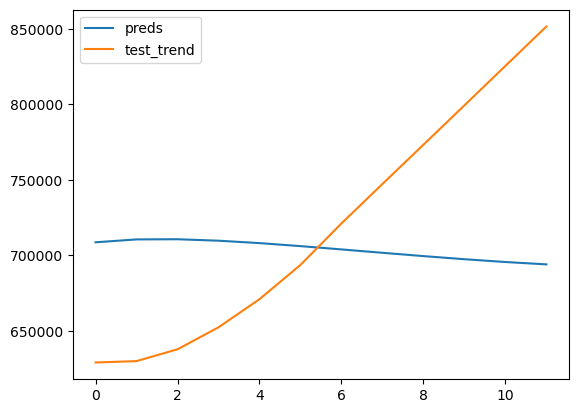

In [22]:
plt.plot(trend_stl.values)
plt.plot(trend_test.values)
plt.legend(["preds", "test_trend"])

In [23]:
train_normal = transform_train(result.seasonal_, format="normal", horizon=horizon)
model = ARIMA(order=(24,1,2), 
            suppress_warnings=True
            )
model.fit(train_normal)

predictions = model.predict(fh=[i for i in range(1, horizon+1)] )
preds_real = reverse_transform_norm_preds(predictions, result.seasonal_, format="normal")


In [24]:
mape(test_stl.values, preds_real.values)  

2.321742124398357

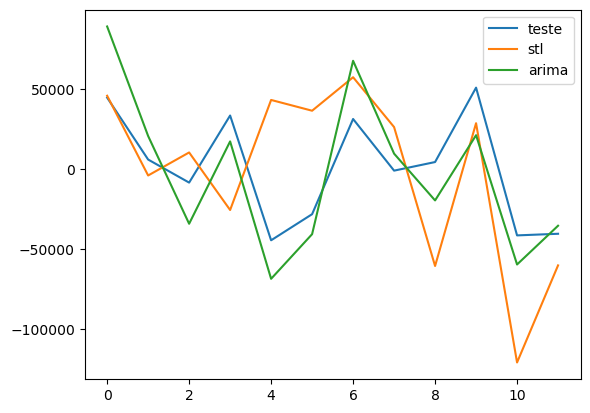

In [25]:
plt.plot(test_stl.values, label="teste")
plt.plot(seasonal_stl.values, label="stl")
plt.plot(preds_real.values, label="arima")
plt.legend()

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

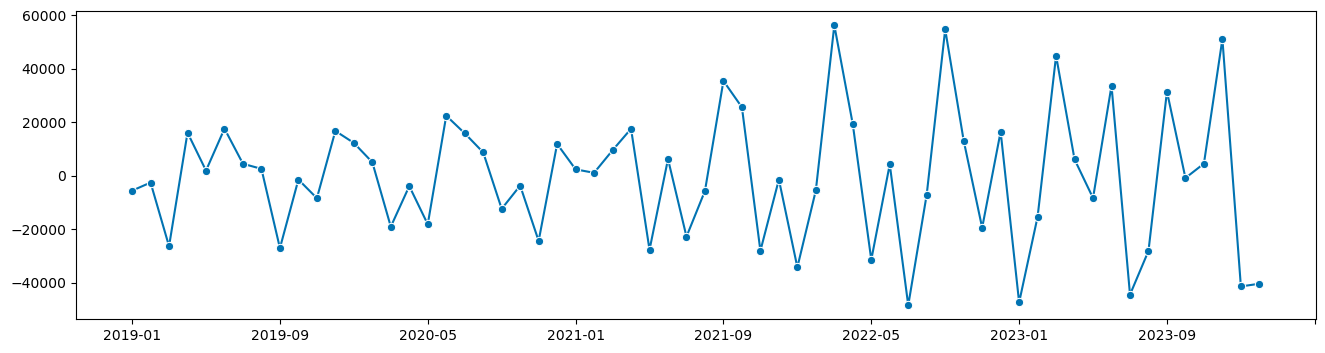

In [26]:
plot_series(ss.seasonal_[-62:])

In [27]:
test_stl.values

array([ 44881.30836983,   6081.4569428 ,  -8365.29860014,  33672.51091156,
       -44513.59602713, -28157.41139846,  31495.74560537,   -869.0945303 ,
         4514.05286635,  51142.7718527 , -41443.88523709, -40428.53858274])

In [28]:
file_path = f"./results/arima/rolling/{derivad}/transform_{estado}.csv"
# file_path_mean = f"./results/arima_mean/rolling/{derivad}/transform_{estado}.csv"
# preds_arima_mean = get_arima_mean(file_path_mean, "arima-mean", test.index)
# preds, params = get_predictions_csv(file_path, "normal", test.index)
# order = (params['p'], params['d'], params['q'])
# train_normal = transform_train(train, format="normal", horizon=horizon)

# # transformer = STLTransformer(sp=12)  
# # result = transformer.fit(train_normal)
# _, preds_noresid, final_order = fit_arima_train(train_normal, train, order, horizon, format="normal")


# # previsao do ruido
# transformer = STLTransformer(sp=12)  
# result = transformer.fit(series)
# series_resid = result.resid_
# data = rolling_window(pd.concat([train_resid, series_resid[-12:]]), window)
# X_train, X_test, y_train, y_test = train_test_split(data, horizon)


# # rf = XGBRegressor()
# rf = xgb.XGBRegressor()
# rf.fit(X_train, y_train)

# predictions = recursive_multistep_forecasting(X_test, rf, horizon)
# mean_norm, std_norm = get_stats_norm(series_resid, horizon, window)

# preds_resid = znorm_reverse(np.array(predictions), mean_norm, std_norm)
# preds_resid = pd.Series(preds_resid, index=test.index)
# preds_hybrid = preds_noresid + preds_resid


In [29]:
# plot_series(test,preds, preds_noresid, preds_hybrid, labels=["test","arima","trend + seasonal","hybrid"])